In [4]:
## imports
import numpy as np
from matplotlib import pyplot as plt
from struct import unpack
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import modeling
import time
import numpy.matlib
%matplotlib widget


In [12]:
## path to datase and number of timestamps 
lines_of_data = 32
filename = "C:/SPAD_ARRAY/release_2208/mainstream/Data/11-4-2022/acq_221104_10"
# filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221017/added_2m_optical_cable_in_IDLER/acq_221017_160843.dat"
filename = "C:/Users/jakub/Documents/LinoSpad2/data/Spectrometer_221129/acq_221129_203647_SPDC_with_BS"

filename = "C:/Users/jakub/Documents/LinoSpad2/data/SPDC_221021/pixel_movement/acq_221021_212530_164_176.dat" #
filename = "C:/Users/jakub/Documents/LinoSpad2/data/Spectrometer_221206/SPDC_BS_512"
filename = "C:/Users/jakub/Documents/LinoSpad2/data/Spectrometer_221206/SPDC_BS_32"


In [13]:
# Read data file 

st = time.time()

rawFile = np.fromfile(filename, dtype=np.uint32) # read data 
data = ((rawFile & 0xFFFFFFF).astype(np.longlong))*1.0#17.857   # Multiply with the lowes bin   
data[np.where(rawFile < 0x80000000)] = -1 # Mask not valid data 
nmrCycles = int(len(data) / lines_of_data / 256)  # number of cycles,
data_matrix = data.reshape((lines_of_data,nmrCycles*256), order='F').reshape((lines_of_data, 256,-1),order='F').transpose((0,2,1)).reshape((-1, 256),order='F').transpose() # reshape the matrix
    
et = time.time()
print('Execution time:', et - st, 'seconds')



Execution time: 5.210292816162109 seconds


In [14]:
# Optional TDC calibration IF USING THIS OPTION CHANGE THE PREVIOUS CODE TO data = (rawFile & 0xFFFFFFF).astype(np.longlong)*1.0 instead od 17.857
tdccal_arr = np.load('tdccal_arr.npy')
offsets_arr = np.load('offsets_arr.npy')

timestampsnmr = lines_of_data
nmr_of_cycles = int(len(data_matrix[0,:]) / timestampsnmr)

for i in range(256):
    ind = np.argwhere(data_matrix[i,:] >= 0)
    data_matrix[i,ind] = (data_matrix[i,ind] - (data_matrix[i,ind] % 140))*17.857 +  tdccal_arr[i,(data_matrix[i,ind] % 140).astype(int)] - offsets_arr[i]

In [15]:
## Compute delta_t fot all combinations between pixels from two ROIs and concatenate them in delta_t_common
timewindow = 50000

# location of two peaks
pixel_array_0 = list(range(128, 159))  #[128,129,130]
pixel_array_1 = list(range(160, 191))  #[128,129,130]

timestampsnmr = lines_of_data
nmr_of_cycles = int(len(data_matrix[pixel_array_0[0]]) / timestampsnmr)

delta_t_common = []
delta_t = []

# Loop over pixels from first peak
for pix_peak0 in pixel_array_0:
    pixel_0 = data_matrix[pix_peak0]
    
    # Loop over pixels from second peak
    for pix_peak1 in pixel_array_1:
        pixel_1 = data_matrix[pix_peak1]
        delta_t = []
        # Compute delta_t between pixels
        for cycle in range(nmr_of_cycles):
            for timestamp_pix0 in range(timestampsnmr):
                if pixel_0[cycle * timestampsnmr + timestamp_pix0] == -1 or pixel_0[
                    cycle * timestampsnmr + timestamp_pix0] <= 1e-9:
                    break
                for timestamp_pix1 in range(timestampsnmr):
                    if pixel_1[cycle * timestampsnmr + timestamp_pix1] == -1 or pixel_1[
                        cycle * timestampsnmr + timestamp_pix1] == 0:
                        break
                    if np.abs(pixel_0[cycle * timestampsnmr + timestamp_pix0] - pixel_1[
                        cycle * timestampsnmr + timestamp_pix1]) < timewindow:
                        delta_t.append(pixel_0[cycle * timestampsnmr + timestamp_pix0] - pixel_1[
                            cycle * timestampsnmr + timestamp_pix1])
                    else:
                        continue

        delta_t_common= np.append(delta_t_common, delta_t)

PIX0: 128
PIX1: 161
PIX0: 128
PIX1: 166
PIX0: 128
PIX1: 170
PIX0: 128
PIX1: 171
PIX0: 128
PIX1: 173
PIX0: 128
PIX1: 188
PIX0: 129
PIX1: 162
PIX0: 129
PIX1: 163
PIX0: 129
PIX1: 176
PIX0: 130
PIX1: 164
PIX0: 130
PIX1: 168
PIX0: 130
PIX1: 174
PIX0: 130
PIX1: 174
PIX0: 131
PIX1: 166
PIX0: 131
PIX1: 170
PIX0: 131
PIX1: 172
PIX0: 131
PIX1: 172
PIX0: 131
PIX1: 174
PIX0: 131
PIX1: 177
PIX0: 131
PIX1: 179
PIX0: 132
PIX1: 175
PIX0: 133
PIX1: 160
PIX0: 133
PIX1: 165
PIX0: 133
PIX1: 169
PIX0: 133
PIX1: 170
PIX0: 133
PIX1: 171
PIX0: 133
PIX1: 173
PIX0: 133
PIX1: 176
PIX0: 133
PIX1: 177
PIX0: 135
PIX1: 167
PIX0: 135
PIX1: 169
PIX0: 135
PIX1: 174
PIX0: 135
PIX1: 176
PIX0: 135
PIX1: 178
PIX0: 135
PIX1: 178
PIX0: 136
PIX1: 163
PIX0: 136
PIX1: 164
PIX0: 136
PIX1: 175
PIX0: 136
PIX1: 182
PIX0: 136
PIX1: 188
PIX0: 137
PIX1: 164
PIX0: 137
PIX1: 165
PIX0: 137
PIX1: 167
PIX0: 137
PIX1: 168
PIX0: 137
PIX1: 171
PIX0: 137
PIX1: 181
PIX0: 137
PIX1: 185
PIX0: 137
PIX1: 188
PIX0: 138
PIX1: 161
PIX0: 138
PIX1: 167


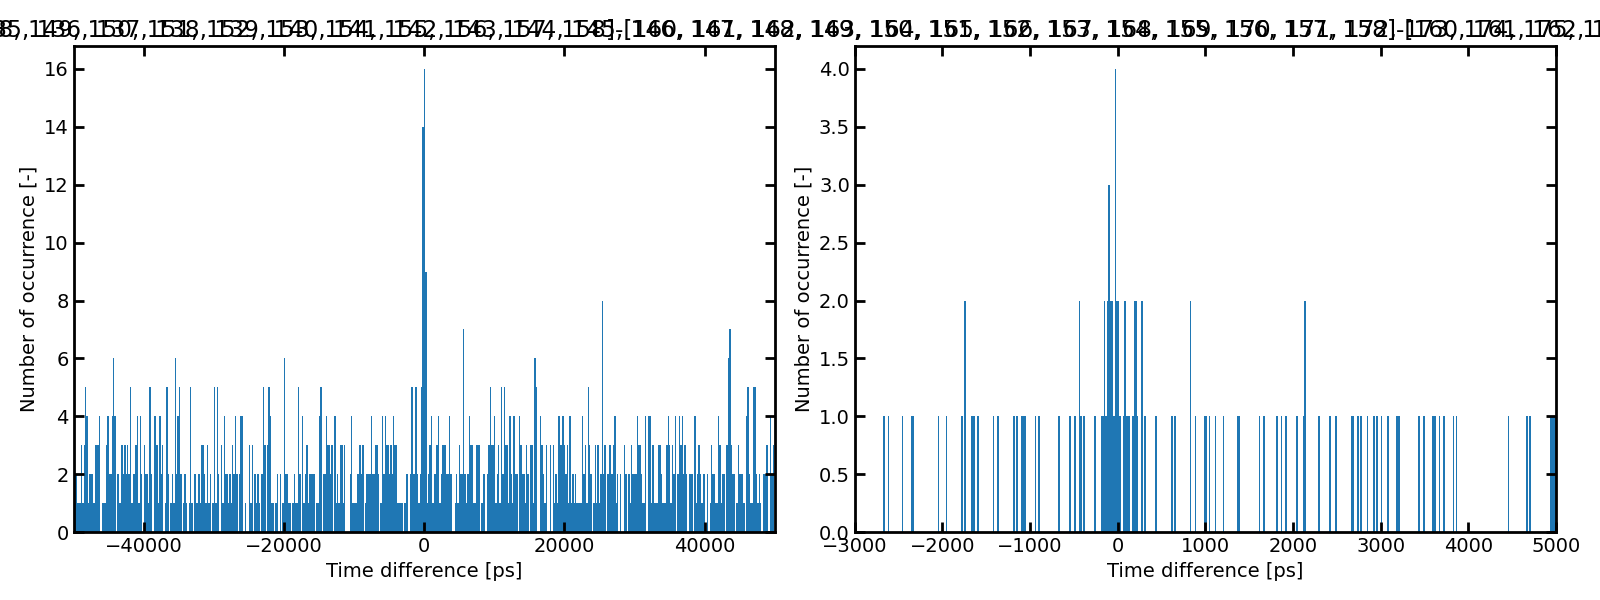

In [16]:
## Plot delta_t of two peaks i.e. delta_t_common from previous code

fig, ax = plt.subplots(1,2)

plt.rcParams.update({"font.size": 14})
x = np.arange(0, 256, 1)

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")

plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(16, 6)

for i in range(2):
    ax[i].tick_params(which="both", width=2, direction="in")
    ax[i].tick_params(which="major", length=7, direction="in")
    ax[i].tick_params(which="minor", length=4, direction="in")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")
    ax[i].set_xlabel("Time difference [ps]")
    ax[i].set_ylabel("Number of occurrence [-]")
    ax[i].set_title("Coincidence rate between peaks {}-{}".format(pixel_array_0,pixel_array_1))
    
for axis in ["top", "bottom", "left", "right"]:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

bins = np.arange(np.min(delta_t_common), np.max(delta_t_common), 17.857 )
bins2 = np.arange(np.min(delta_t_common), np.max(delta_t_common), 100 )
ax[0].hist(delta_t_common, bins=500)
ax[1].hist(delta_t_common, bins=bins)
ax[0].set_xlim(-timewindow, timewindow)
ax[1].set_xlim(-3000, 5000)

fig.tight_layout(pad=1.0)